# Classification result tuning and Plots

In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns ; sns.set()

from google.colab import drive
drive.mount('/content/drive')

sys.path.append("/content/drive/MyDrive/GSOC-NMR-project/Work/Notebooks")
from auxillary_functions import *
from polynomial_featextract import poly_featextract

Mounted at /content/drive


In [2]:
# import raw data and params.txt file
datadir_path = "/content/drive/MyDrive/GSOC-NMR-project/Work/Data/2021-06-21_classify_datagen_all_funcs"

rawdata = load_data(datadir_path)
params = load_params(datadir_path)
ker_integrals = load_wlist(datadir_path) # load wlist.txt file

# Stencil type : {'0' : 'Gaussian', '1' : 'Power Law', '2' : 'RKKY'}

Finished loading rawdata into numpy array
Finsihed loading parameters file
finished loading kernel-integrals file.


In [3]:
print(rawdata.shape)
offset = 150
shifted_data, center = get_window(rawdata,2/3,width=offset)
print("The Echo pulse occurs at timestep:",center)

# Rescaled data
rscl_data = shifted_data / np.max(shifted_data,axis=1,keepdims=True)

(10500, 943)
The Echo pulse occurs at timestep: 628


# Classification

## Pointwise features

In [4]:
import sklearn 
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, f1_score, classification_report

In [5]:
X_train , X_test, y_train, y_test = train_test_split(rscl_data, params['stencil_type'], test_size=0.2,
                                                     stratify=params['stencil_type'], random_state=101)

In [6]:
model = RandomForestClassifier(oob_score=True, n_jobs=-1)


### Search (Grid /Random)

In [ ]:
model_params = {
    'n_estimators' : [int(x) for x in np.linspace(10, 121, 10)],
    'min_samples_split' : [2, 5, 10],
    'min_samples_leaf' : [1, 2, 4],
    'bootstrap' : [True, False],
}


In [ ]:
gs = GridSearchCV(estimator=model, param_grid=params, cv=3, n_jobs=-1, verbose=True)

In [ ]:
rf_random = RandomizedSearchCV(estimator = model, param_distributions = model_params,
                               n_iter = 100, cv = 3, verbose=2,scoring='f1_weighted',
                               random_state=42, n_jobs = -1)

In [ ]:
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  8.0min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [ ]:
pd.DataFrame(rf_random.cv_results_) #.plot.scatter('mean_fit_time', 'param_n_estimators', ls='-')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_bootstrap,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,11.274632,0.063215,0.106437,0.000548,121,5,1,True,"{'n_estimators': 121, 'min_samples_split': 5, ...",0.967475,0.964920,0.961092,0.964496,0.002623,5
1,3.429991,0.097327,0.122174,0.008279,34,5,2,True,"{'n_estimators': 34, 'min_samples_split': 5, '...",0.967140,0.959165,0.953940,0.960082,0.005427,25
2,0.010130,0.000515,0.000000,0.000000,47,2,4,False,"{'n_estimators': 47, 'min_samples_split': 2, '...",NaN,NaN,NaN,NaN,NaN,68
3,9.984222,0.189958,0.121968,0.011910,108,5,4,True,"{'n_estimators': 108, 'min_samples_split': 5, ...",0.961766,0.957392,0.951083,0.956747,0.004385,38
4,0.021285,0.001658,0.000000,0.000000,71,10,2,False,"{'n_estimators': 71, 'min_samples_split': 10, ...",NaN,NaN,NaN,NaN,NaN,69
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1.923053,0.165320,0.126767,0.003468,22,10,4,True,"{'n_estimators': 22, 'min_samples_split': 10, ...",0.958942,0.954843,0.953176,0.955654,0.002423,43
96,10.878857,0.163669,0.190893,0.059411,121,5,4,True,"{'n_estimators': 121, 'min_samples_split': 5, ...",0.961028,0.959205,0.953921,0.958051,0.003014,32
97,5.553440,0.205368,0.118848,0.008233,59,10,4,True,"{'n_estimators': 59, 'min_samples_split': 10, ...",0.957504,0.956701,0.953952,0.956053,0.001521,40
98,10.140834,2.177295,0.145752,0.056884,121,2,2,True,"{'n_estimators': 121, 'min_samples_split': 2, ...",0.967498,0.962047,0.960401,0.963315,0.003033,7


In [ ]:
rf_random.best_params_

{'bootstrap': True,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 34}

In [ ]:
rscv_model = RandomForestClassifier(random_state=0, n_estimators=34, min_samples_split=2, min_samples_leaf=1)

In [ ]:
rscv_model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=34,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [ ]:
ypred_rscv = rscv_model.predict(X_test)
print(f1_score(y_test, ypred_rscv, average='weighted'))

0.9786348366440947


In [ ]:
report = classification_report(y_test, ypred_rscv, labels=[0,1,2],target_names =['Gaussian','Power Law','RKKY'])
print(report)

              precision    recall  f1-score   support

    Gaussian       0.99      0.97      0.98       700
   Power Law       1.00      0.99      0.99       700
        RKKY       0.95      0.98      0.97       700

    accuracy                           0.98      2100
   macro avg       0.98      0.98      0.98      2100
weighted avg       0.98      0.98      0.98      2100



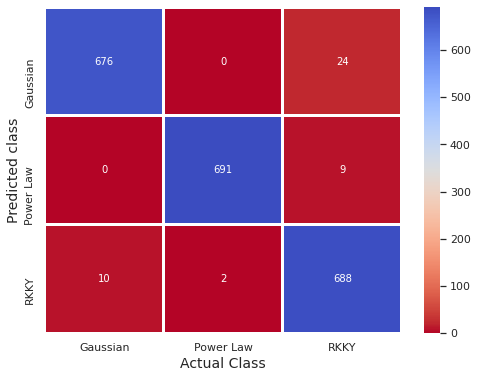

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(confusion_matrix(y_test, ypred_rscv), annot=True, fmt='.0f',
            cmap='coolwarm_r', lw=2)
plt.xlabel('Actual Class', fontsize=14)
plt.ylabel('Predicted class', fontsize=14)

plt.xticks(np.arange(3)+0.5,['Gaussian','Power Law','RKKY'])
plt.yticks(np.arange(3)+0.5,['Gaussian','Power Law','RKKY'])


plt.show()

In [ ]:
gs.fit(X_train, y_train)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 10.1min
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed: 11.0min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=-1,
                                              oob_score=True, random_state=None,
                                   

In [ ]:
pd.DataFrame(gs.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_min_samples_leaf,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,8.788820,0.282849,0.128046,0.002806,0.5,2,10,"{'max_features': 0.5, 'min_samples_leaf': 2, '...",0.963214,0.948571,0.948214,0.953333,0.006988,17
1,34.586487,0.565970,0.110883,0.004760,0.5,2,40,"{'max_features': 0.5, 'min_samples_leaf': 2, '...",0.963571,0.956429,0.960357,0.960119,0.002921,6
2,85.170913,1.206531,0.147703,0.057256,0.5,2,100,"{'max_features': 0.5, 'min_samples_leaf': 2, '...",0.966429,0.961429,0.958929,0.962262,0.003118,2
3,8.673831,0.290974,0.129424,0.000816,0.5,3,10,"{'max_features': 0.5, 'min_samples_leaf': 3, '...",0.961786,0.949286,0.945714,0.952262,0.006890,19
4,33.954132,0.421754,0.126374,0.002854,0.5,3,40,"{'max_features': 0.5, 'min_samples_leaf': 3, '...",0.962500,0.956429,0.952857,0.957262,0.003981,12
5,83.072977,1.001672,0.118568,0.010427,0.5,3,100,"{'max_features': 0.5, 'min_samples_leaf': 3, '...",0.967143,0.957143,0.953214,0.959167,0.005864,7
6,8.595788,0.347642,0.127356,0.002856,0.5,5,10,"{'max_features': 0.5, 'min_samples_leaf': 5, '...",0.948929,0.937500,0.946786,0.944405,0.004960,25
7,31.401692,0.672682,0.131974,0.002604,0.5,5,40,"{'max_features': 0.5, 'min_samples_leaf': 5, '...",0.957500,0.950000,0.949643,0.952381,0.003623,18
8,78.763837,2.999469,0.104736,0.000364,0.5,5,100,"{'max_features': 0.5, 'min_samples_leaf': 5, '...",0.960714,0.953929,0.948214,0.954286,0.005109,16
9,1.059335,0.050701,0.130199,0.001358,sqrt,2,10,"{'max_features': 'sqrt', 'min_samples_leaf': 2...",0.960000,0.957143,0.952500,0.956548,0.003091,13


In [ ]:
gs.best_params_

{'max_features': 'sqrt', 'min_samples_leaf': 2, 'n_estimators': 100}

In [ ]:
rf = RandomForestClassifier(random_state=0, **gs.best_params_)

In [ ]:
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [ ]:
rf.score(X_test, y_test)

0.9785714285714285

In [ ]:
y_pred_gs = rf.predict(X_test)
print(f1_score(y_test, y_pred_gs, average='weighted'))

0.9786407952007219


In [ ]:
scores = cross_val_score(model, X_train, y_train, scoring='f1_weighted', cv=5, n_jobs=-1, verbose=True )

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.2min finished


In [ ]:
scores

array([0.96839617, 0.96963515, 0.96715564, 0.96421602, 0.95955429])

In [ ]:
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=0.7,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=-1,
                       oob_score=True, random_state=None, verbose=0,
                       warm_start=False)

In [ ]:
y_pred = model.predict(X_test)
f1_score(y_test, y_pred, average='weighted')

In [ ]:
report = classification_report(y_test, y_pred, labels=[0,1,2],target_names =['Gaussian','Power Law','RKKY'])
print(report)

              precision    recall  f1-score   support

    Gaussian       0.98      0.96      0.97       700
   Power Law       1.00      0.99      0.99       700
        RKKY       0.96      0.99      0.97       700

    accuracy                           0.98      2100
   macro avg       0.98      0.98      0.98      2100
weighted avg       0.98      0.98      0.98      2100



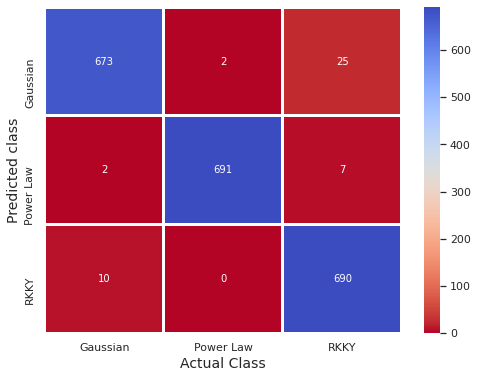

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='.0f',
            cmap='coolwarm_r', lw=2)
plt.xlabel('Actual Class', fontsize=14)
plt.ylabel('Predicted class', fontsize=14)

plt.xticks(np.arange(3)+0.5,['Gaussian','Power Law','RKKY'])
plt.yticks(np.arange(3)+0.5,['Gaussian','Power Law','RKKY'])


plt.show()

In [ ]:
model.feature_importances_

### wrongly classified curves

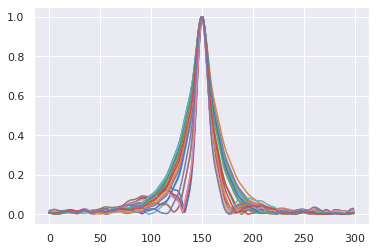

In [ ]:
gs_rkky = ((y_test == 0)&(y_pred == 2))
gs_rkky = gs_rkky[gs_rkky == True].index
for curve in rscl_data[gs_rkky,:]:
    plt.plot(curve)

In [ ]:
wrongly_classified = np.where(y_test != y_pred)[0]
wrongly_classified

array([   7,   37,  227,  334,  371,  464,  538,  564,  693,  757,  761,
        831,  900,  949, 1029, 1081, 1089, 1135, 1164, 1186, 1193, 1235,
       1245, 1250, 1257, 1260, 1277, 1281, 1317, 1344, 1365, 1397, 1454,
       1464, 1501, 1524, 1545, 1556, 1670, 1722, 1752, 1808, 1842, 1945,
       1984, 2073])

In [ ]:
y_test.iloc[wrongly_classified].iloc[0]

0.0

In [ ]:
y_pred[wrongly_classified]

array([2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 0., 2., 2., 0., 2., 0., 2.,
       0., 2., 0., 2., 2., 2., 2., 2., 2., 2., 2., 1., 2., 2., 0., 2., 1.,
       1., 2., 0., 1., 2., 2., 0., 2.], dtype=float32)

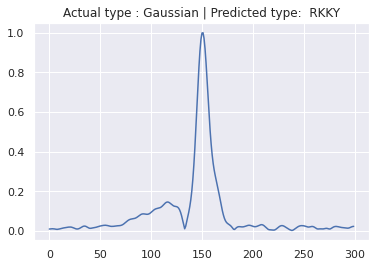

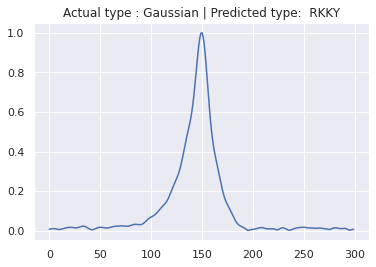

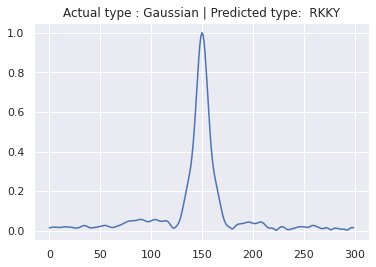

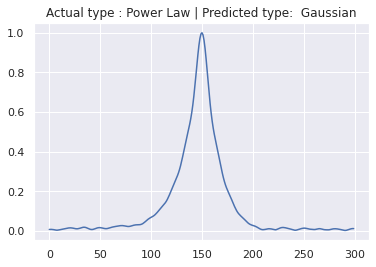

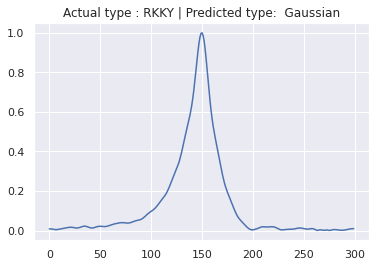

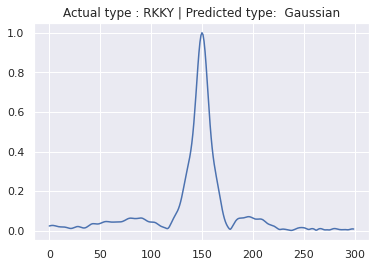

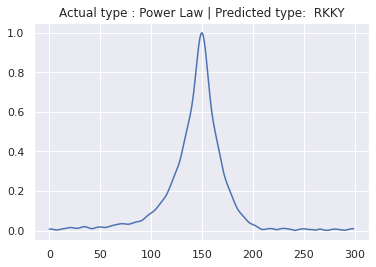

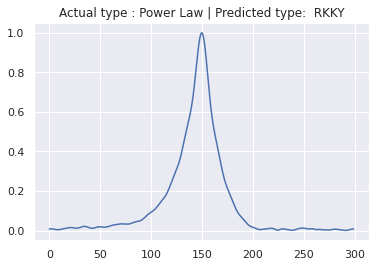

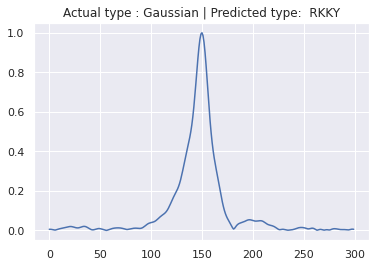

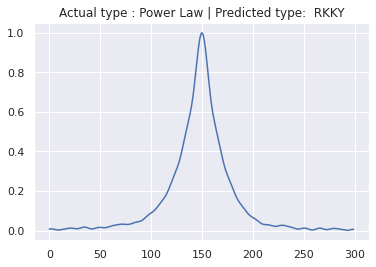

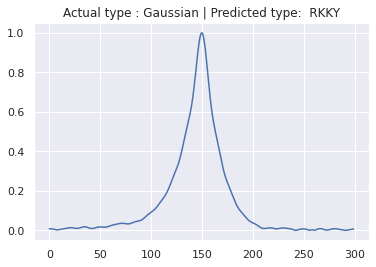

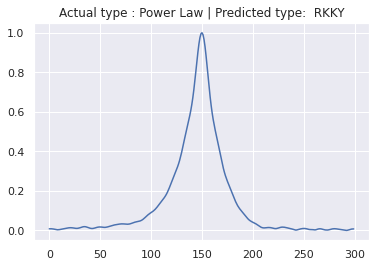

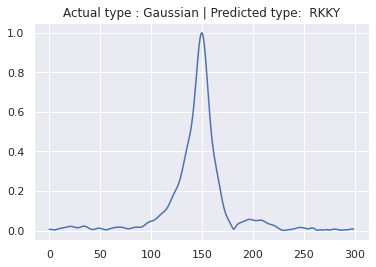

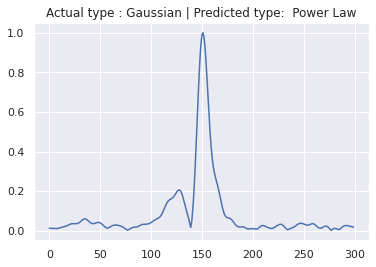

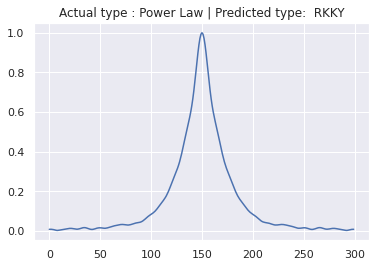

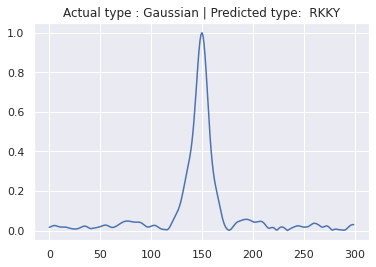

In [ ]:
stencil_type = {0 : 'Gaussian', 1 : 'Power Law', 2 : 'RKKY'}
wrongly_classified_x = rscl_data[y_test.iloc[wrongly_classified].index]
for i in range(0,len(wrongly_classified),3):
    fig,ax = plt.subplots()
    plt.plot(wrongly_classified_x[i,:])
    actual_label = y_test.iloc[wrongly_classified].iloc[i]
    pred_label = y_pred[wrongly_classified][i]
    plt.title(f"Actual type : {stencil_type[actual_label]} | Predicted type:  {stencil_type[pred_label]}")